In [1]:
import pandas as pd
import numpy as np
import joblib
import os
import seaborn as sns
import sklearn as skl
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

# 1. הגדרת נתיבים ושמות הקבצים
# ודאו שכל קבצי ה-CSV נמצאים באותה תיקייה עם המחברת
# אנו מגדירים מילון שממפה קובץ -> סוג ההתקפה העיקרי שיש בו
files = {
    '../data/raw/Wednesday-workingHours.pcap_ISCX.csv': 'DoS',
    '../data/raw/Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv': 'PortScan',
    '../data/raw/Tuesday-WorkingHours.pcap_ISCX.csv': 'BruteForce',
    '../data/raw/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv': 'WebAttack'
}

dataframes = []


In [2]:
# כמות דגימה מקסימלית מכל סוג התקפה (כדי לא לפוצץ את הזיכרון)
# 50,000 שורות מכל סוג זה די והותר לפרויקט גמר
SAMPLES_PER_CLASS = 50000

for filename, attack_type in files.items():
    if os.path.exists(filename):
        print(f"Loading {filename}...")
        df = pd.read_csv(filename)
        
        # ניקוי רווחים בשמות העמודות
        df.columns = df.columns.str.strip()
        
        # טיפול ב-Label
        # אנחנו רוצים לשמור את ה-Label המקורי כרגע כדי לסנן
        # בקבצים האלה יש גם תעבורה תקינה (BENIGN) וגם התקפות
        
        # 1. לקיחת התקפות (מה שמעניין אותנו בקובץ הזה)
        df_attack = df[df['Label'] != 'BENIGN'].copy()
        # אם יש יותר מדי, לוקחים דגימה אקראית
        if len(df_attack) > SAMPLES_PER_CLASS:
            df_attack = df_attack.sample(n=SAMPLES_PER_CLASS, random_state=42)
        
        # 2. לקיחת תעבורה תקינה (BENIGN)
        # ניקח קצת מכל קובץ כדי שהמודל יכיר תעבורה תקינה מגוונת (מימים שונים)
        df_benign = df[df['Label'] == 'BENIGN'].copy()
        if len(df_benign) > (SAMPLES_PER_CLASS // 4): 
            df_benign = df_benign.sample(n=(SAMPLES_PER_CLASS // 4), random_state=42)
            
        # איחוד זמני
        df_combined = pd.concat([df_attack, df_benign])
        dataframes.append(df_combined)
        print(f"  -> Added {len(df_attack)} attacks and {len(df_benign)} benign records.")
        
    else:
        print(f"WARNING: File {filename} not found!")

Loading ../data/raw/Wednesday-workingHours.pcap_ISCX.csv...
  -> Added 50000 attacks and 12500 benign records.
Loading ../data/raw/Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv...
  -> Added 50000 attacks and 12500 benign records.
Loading ../data/raw/Tuesday-WorkingHours.pcap_ISCX.csv...
  -> Added 13835 attacks and 12500 benign records.
Loading ../data/raw/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv...
  -> Added 2180 attacks and 12500 benign records.



Data Merging Complete!
Total Rows: 166015
Label Distribution:
Label
BENIGN                        50000
PortScan                      50000
DoS Hulk                      45851
FTP-Patator                    7938
SSH-Patator                    5897
DoS GoldenEye                  2003
Web Attack � Brute Force       1507
DoS slowloris                  1089
DoS Slowhttptest               1055
Web Attack � XSS                652
Web Attack � Sql Injection       21
Heartbleed                        2
Name: count, dtype: int64


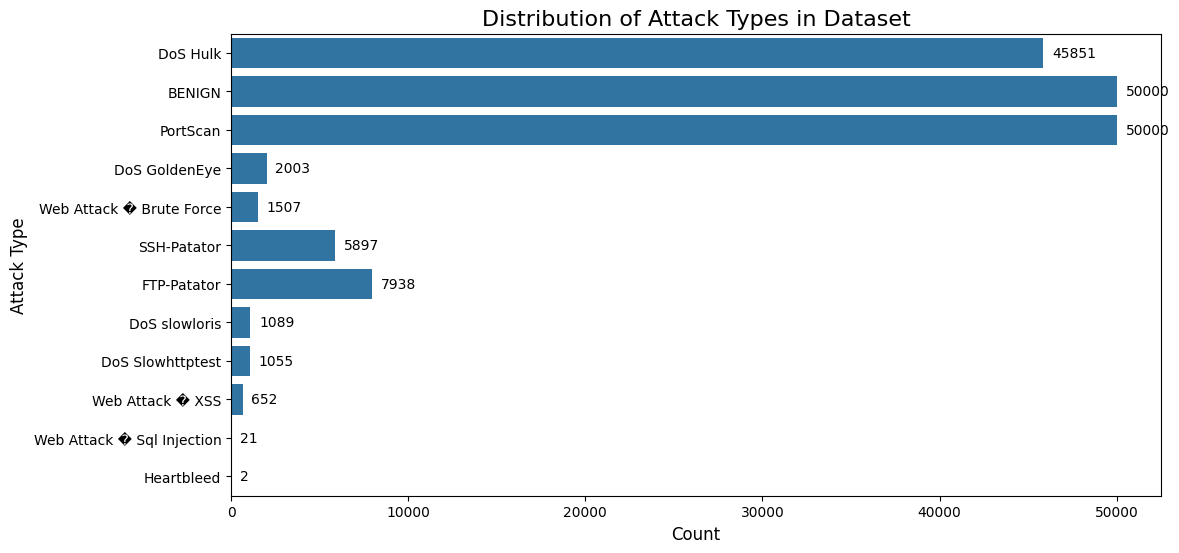

In [3]:
# איחוד כל הדאטה-פריימים לטבלה אחת ענקית
if dataframes:
    master_df = pd.concat(dataframes, ignore_index=True)
    # ערבוב השורות (Shuffle) כדי שהסדר לא ישנה
    master_df = master_df.sample(frac=1, random_state=42).reset_index(drop=True)

    # add a save of the master_df into a csv file in the data/processed folder
    processed_path = '../data/processed/'
    master_csv_file = os.path.join(processed_path, 'master_dataset.csv')
    master_df.to_csv(master_csv_file, index=False)
    
    print("\nData Merging Complete!")
    print(f"Total Rows: {master_df.shape[0]}")
    print("Label Distribution:")
    print(master_df['Label'].value_counts())
else:
    print("No data loaded. Check file names.")

# הגדרת גודל הגרף (רוחב, גובה)
plt.figure(figsize=(12, 6))

# שימוש ב-Seaborn ליצירת גרף עמודות (Count Plot)
# order=... מסדר את העמודות מהגדול לקטן, שיהיה נעים לעין
ax = sns.countplot(y=master_df['Label']) 

# כותרות
plt.title('Distribution of Attack Types in Dataset', fontsize=16)
plt.xlabel('Count', fontsize=12)
plt.ylabel('Attack Type', fontsize=12)

# הוספת המספר המדויק בקצה של כל עמודה (כדי שלא נצטרך לנחש)
for p in ax.patches:
    width = p.get_width()
    plt.text(width + 500,    # מיקום X (קצת אחרי העמודה)
             p.get_y() + p.get_height() / 2, # מיקום Y (אמצע העמודה)
             '{:1.0f}'.format(width), # המספר עצמו
             ha = 'left',   # יישור
             va = 'center') # יישור אנכי

# הצגת הגרף
plt.show()    

In [4]:
# 1. ניקוי עמודות מזהות ("החשודים המיידיים")
# אנחנו מוחקים אותן כדי שהמודל ילמד התנהגות ולא יזכור כתובות IP

# פונקציה למיפוי השמות הארוכים לקטגוריות מספרים
def map_attack_label(label):
    label = str(label).strip() # ניקוי רווחים למקרה שנשארו
    
    if label == 'BENIGN':
        return 0
    elif 'DoS' in label: # תופס את כל סוגי ה-DoS (Hulk, GoldenEye, etc.)
        return 1
    elif 'PortScan' in label:
        return 2
    elif 'Patator' in label: # FTP-Patator, SSH-Patator (Brute Force)
        return 3
    elif 'Web Attack' in label: # XSS, Sql Injection, Brute Force
        return 4
    else:
        return 5 # קטגוריה לכל מה שלא תפסנו (למשל Heartbleed אם קיים)

# 2. יישום המיפוי
print("Mapping labels to numeric categories...")
master_df['Label_Category'] = master_df['Label'].apply(map_attack_label)

# בדיקה שלא פספסנו כלום (שאין קטגוריה 5)
print("New Label Categories Distribution:")
print(master_df['Label_Category'].value_counts())

selected_features = [
    'Destination Port',
    'Flow Duration',
    'Total Fwd Packets',
    'Flow Bytes/s',
    'Flow Packets/s',
    'SYN Flag Count',
    'RST Flag Count',
    'PSH Flag Count',
    'ACK Flag Count'
]
print(f"Selecting ONLY these features: {selected_features}")

# בדיקה שכולם קיימים
missing = [f for f in selected_features if f not in master_df.columns]
if missing:
    print(f"❌ Error: Missing columns in CSV: {missing}")
    exit()


X = master_df[selected_features].copy()
y = master_df['Label_Category']

# 4. טיפול בערכים אינסופיים וחסרים (חובה לפני אימון)
X.replace([np.inf, -np.inf], np.nan, inplace=True)
# מחיקת שורות עם NaN (בדרך כלל אחוז מזערי)
# אנחנו צריכים לוודא שאנחנו מוחקים גם ב-y את אותן שורות!
data_final = X.copy()
data_final['target'] = y
data_final.dropna(inplace=True)

# הפרדה מחדש אחרי הניקוי
X_final = data_final.drop(columns=['target'])
y_final = data_final['target']

print("\nPreprocessing Complete!")
print(f"Final Features count: {X_final.shape[1]}")
print(f"Final Samples count: {X_final.shape[0]}")

Mapping labels to numeric categories...
New Label Categories Distribution:
Label_Category
0    50000
2    50000
1    49998
3    13835
4     2180
5        2
Name: count, dtype: int64
Selecting ONLY these features: ['Destination Port', 'Flow Duration', 'Total Fwd Packets', 'Flow Bytes/s', 'Flow Packets/s', 'SYN Flag Count', 'RST Flag Count', 'PSH Flag Count', 'ACK Flag Count']

Preprocessing Complete!
Final Features count: 9
Final Samples count: 165747


In [5]:
# 1. בדיקה כמה כפילויות יש כרגע
print(f"Original shape: {X.shape}")
duplicate_count = X.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_count}")

# 2. איחוד זמני כדי למחוק כפילויות (צריך גם את ה-Label כדי לוודא שזו אותה שורה בדיוק)
temp_df = X.copy()
temp_df['target_label_for_drop'] = y

# מחיקת כפילויות
temp_df.drop_duplicates(inplace=True)

# החזרה למצב הקודם
X_unique = temp_df.drop(columns=['target_label_for_drop'])
y_unique = temp_df['target_label_for_drop']

print(f"Shape after removing duplicates: {X_unique.shape}")
print(f"Deleted {duplicate_count} rows.")

Original shape: (166015, 9)
Number of duplicate rows: 33287
Shape after removing duplicates: (132849, 9)
Deleted 33287 rows.


Splitting data...
Training Random Forest Model (Multi-Class)...
Training Complete!
Predicting on Test set...

--- Classification Report ---
              precision    recall  f1-score   support

      Benign     0.9915    0.9900    0.9907     10000
         DoS     0.9945    0.9968    0.9957     10000
    PortScan     0.9997    0.9991    0.9994     10000
  BruteForce     0.9986    0.9986    0.9986      2767
   WebAttack     0.8664    0.8624    0.8644       436

    accuracy                         0.9938     33203
   macro avg     0.9701    0.9694    0.9697     33203
weighted avg     0.9938    0.9938    0.9938     33203



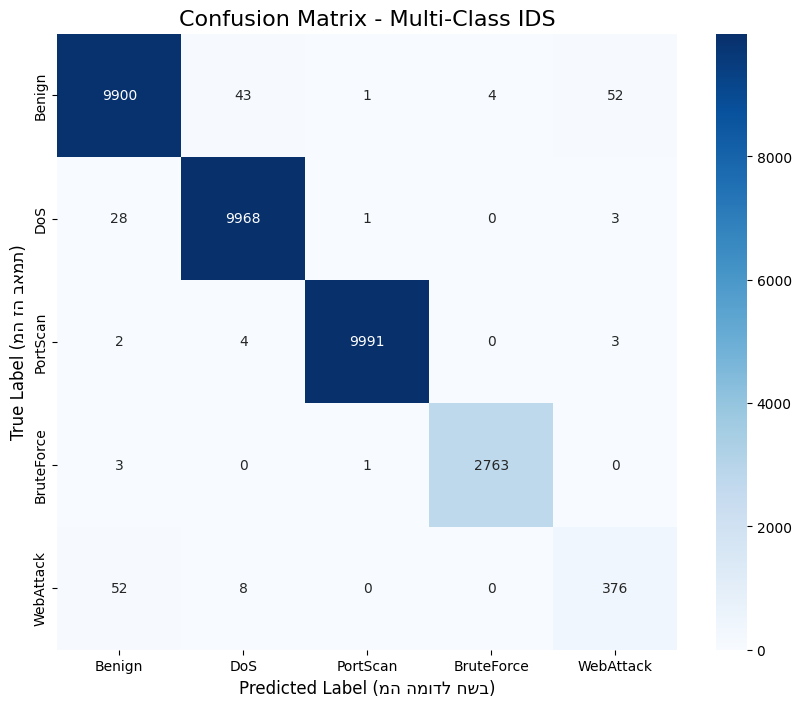

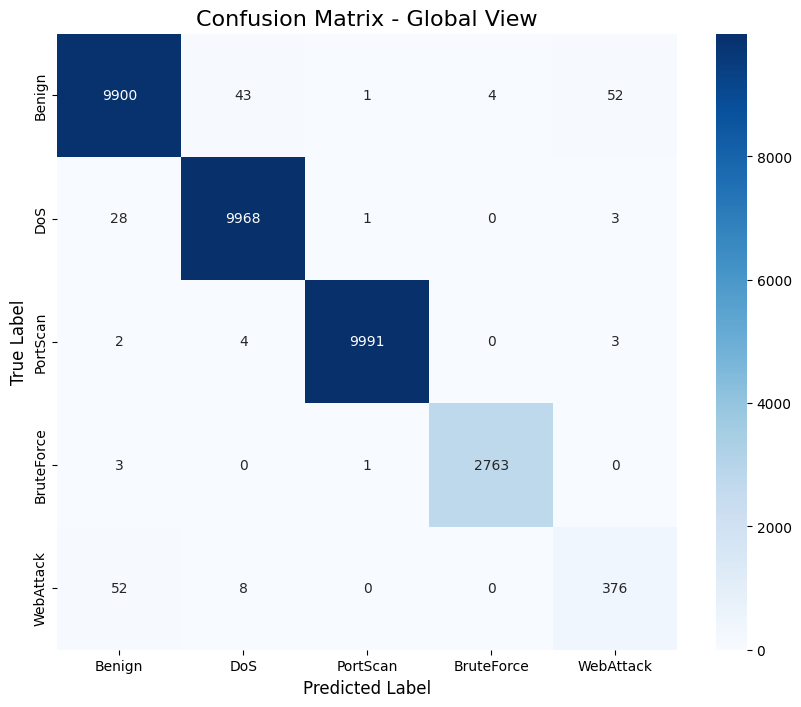

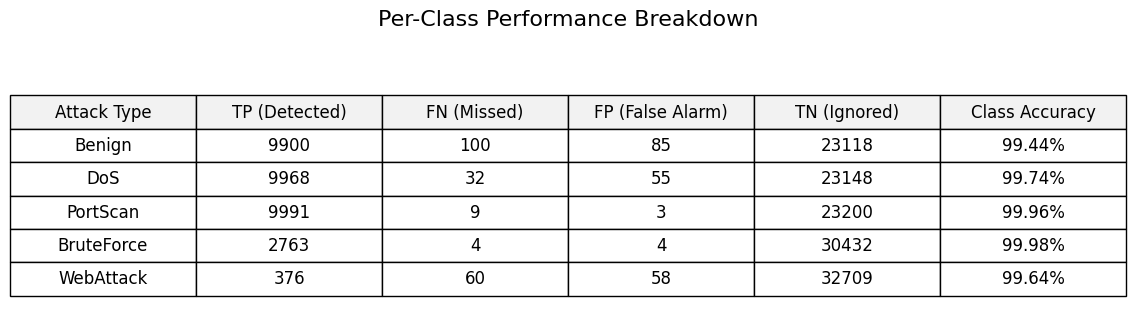

In [6]:

# 1. חלוקה לסט אימון וסט בדיקה
# stratify=y מבטיח שאחוז ההתקפות מכל סוג יישמר זהה גם באימון וגם בטסט
print("Splitting data...")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 2. אימון המודל
print("Training Random Forest Model (Multi-Class)...")
# n_jobs=-1 משתמש בכל הליבות של המעבד כדי לסיים מהר
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)
print("Training Complete!")

# 3. ביצוע תחזית על סט הבדיקה
print("Predicting on Test set...")
y_pred = rf_model.predict(X_test)

# --- תצוגת תוצאות ---
# מילון להמרת המספרים חזרה לשמות (בשביל הגרף)
label_map = {0: 'Benign', 1: 'DoS', 2: 'PortScan', 3: 'BruteForce', 4: 'WebAttack'}
target_names = [label_map[i] for i in sorted(label_map.keys()) if i in y.unique()]

# א. דוח טקסטואלי
print("\n--- Classification Report ---")
print(classification_report(y_test, y_pred, target_names=target_names, digits=4))

# ב. מטריצת בלבול ויזואלית (ה-Show של הפרויקט)
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names,
            yticklabels=target_names)

plt.title('Confusion Matrix - Multi-Class IDS', fontsize=16)
plt.ylabel('True Label (מה זה באמת)', fontsize=12)
plt.xlabel('Predicted Label (מה המודל חשב)', fontsize=12)
plt.show()

# 1. הצגת המטריצה הגדולה (הרגילה והטובה)
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names,
            yticklabels=target_names)
plt.title('Confusion Matrix - Global View', fontsize=16)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.show()

# ---------------------------------------------------------
# 2. יצירת טבלה מסכמת לכל התקפה בנפרד (TP, TN, FP, FN)
# ---------------------------------------------------------

# חישוב המדדים לכל מחלקה בנפרד
mcm = multilabel_confusion_matrix(y_test, y_pred)

results = []
for i, attack_name in enumerate(target_names):
    # שליפת המטריצה הקטנה של 2X2 עבור ההתקפה הספציפית
    # המבנה הוא: [[TN, FP], [FN, TP]]
    tn = mcm[i][0, 0]
    fp = mcm[i][0, 1]
    fn = mcm[i][1, 0]
    tp = mcm[i][1, 1]
    
    total = tn + fp + fn + tp
    accuracy = (tp + tn) / total
    
    results.append({
        "Attack Type": attack_name,
        "TP (Detected)": tp,       # כמה תפסנו נכון
        "FN (Missed)": fn,         # כמה פספסנו (מסוכן!)
        "FP (False Alarm)": fp,    # כמה סתם צעקנו
        "TN (Ignored)": tn,        # כמה היינו בשקט בצדק
        "Class Accuracy": f"{accuracy:.2%}" # דיוק ספציפי להתקפה זו
    })

# המרה ל-DataFrame של פנדס לתצוגה יפה
df_results = pd.DataFrame(results)

# ציור הטבלה כתמונה (כדי שזה יראה כמו חלק מהדוח)
plt.figure(figsize=(12, 3)) # גובה נמוך כי זו רק טבלה
plt.axis('off') # בלי צירים מסביב
plt.title("Per-Class Performance Breakdown", fontsize=16, y=1.2)

# יצירת הטבלה הויזואלית
table = plt.table(cellText=df_results.values,
                  colLabels=df_results.columns,
                  cellLoc='center',
                  loc='center',
                  colColours=['#f2f2f2']*len(df_results.columns)) # צבע כותרת אפור בהיר

table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.2, 2) # ריווח של השורות (גובה ורוחב)

plt.show()

שמירת המודל לאחר אימון והצגת נתונים על זיהוי של 20% הנתונים שנשמרו לבדיקה

In [7]:
# 1. שמירת המודל עצמו
# זה יוצר קובץ בינארי שמכיל את כל 100 העצים של היער
joblib.dump(rf_model, '../src/models/multiClass_ids_model_rf.pkl')

# 2. שמירת רשימת הפיצ'רים (הכותרות)
# זה קריטי! המודל חייב לקבל את העמודות בדיוק באותו סדר בבדיקה החיצונית
# אנחנו שומרים את שמות העמודות ששימשו לאימון (X_train)
feature_list = list(X_train.columns)
joblib.dump(feature_list, '../src/models/model_features.pkl')

print("Files created successfully:")
print("1. multiClass_ids_model_rf.pkl (The Brain)")
print(f"2. model_features.pkl (The List of {len(feature_list)} features)")

Files created successfully:
1. multiClass_ids_model_rf.pkl (The Brain)
2. model_features.pkl (The List of 9 features)


ניסיון זיהוי של המודל מול מידע של קובץ מ 2018

In [8]:
# 1. טעינה
print("--- Debugging Column Names ---")
model_features = joblib.load('../src/models/model_features.pkl')
df_2018 = pd.read_csv('../data/raw/02-15-2018.csv', nrows=5) # טוען רק 5 שורות

# 2. הדפסה השוואתית
print(f"\n1. Model expects {len(model_features)} features.")
print("First 5 features expected by Model:")
print([f"'{f}'" for f in model_features[:5]]) # הוספתי גרשיים כדי לראות אם יש רווחים

print(f"\n2. CSV file has {len(df_2018.columns)} columns.")
print("First 5 columns in CSV file:")
print([f"'{c}'" for c in df_2018.columns[:5]])

# 3. בדיקה ספציפית על עמודה אחת ידועה
print("\n3. Specific Check for 'Total Fwd Packets':")
key = 'Total Fwd Packets'
target = 'Tot Fwd Pkts'

if key in model_features:
    print(f"✅ '{key}' is in model features.")
else:
    print(f"❌ '{key}' NOT found in model features!")

if target in df_2018.columns:
    print(f"✅ '{target}' is in CSV columns.")
elif target.strip() in df_2018.columns:
     print(f"⚠️ '{target}' found but with spaces!")
else:
    print(f"❌ '{target}' NOT found in CSV columns!")

--- Debugging Column Names ---

1. Model expects 9 features.
First 5 features expected by Model:
["'Destination Port'", "'Flow Duration'", "'Total Fwd Packets'", "'Flow Bytes/s'", "'Flow Packets/s'"]

2. CSV file has 80 columns.
First 5 columns in CSV file:
["'Dst Port'", "'Protocol'", "'Timestamp'", "'Flow Duration'", "'Tot Fwd Pkts'"]

3. Specific Check for 'Total Fwd Packets':
✅ 'Total Fwd Packets' is in model features.
✅ 'Tot Fwd Pkts' is in CSV columns.


In [9]:
# 1. טעינת המשאבים
print("Loading model and features...")
rf_model = joblib.load('../src/models/multiClass_ids_model_rf.pkl')
model_features = joblib.load('../src/models/model_features.pkl')

# 2. טעינת הדאטה החיצוני (2018)
print("Loading 2018 data...")
df_2018 = pd.read_csv('../data/raw/02-15-2018.csv', nrows=50000)

# ניקוי רווחים אגרסיבי משמות העמודות בקובץ
df_2018.columns = df_2018.columns.str.strip()

# 3. מילון התרגום המלא (2017 -> 2018)
mapping = {
    # Packet counts & lengths
    'Total Fwd Packets': 'Tot Fwd Pkts',
    'Total Backward Packets': 'Tot Bwd Pkts',
    'Total Length of Fwd Packets': 'TotLen Fwd Pkts',
    'Total Length of Bwd Packets': 'TotLen Bwd Pkts',
    'Fwd Packet Length Max': 'Fwd Pkt Len Max',
    'Fwd Packet Length Min': 'Fwd Pkt Len Min',
    'Fwd Packet Length Mean': 'Fwd Pkt Len Mean',
    'Fwd Packet Length Std': 'Fwd Pkt Len Std',
    'Bwd Packet Length Max': 'Bwd Pkt Len Max',
    'Bwd Packet Length Min': 'Bwd Pkt Len Min',
    'Bwd Packet Length Mean': 'Bwd Pkt Len Mean',
    'Bwd Packet Length Std': 'Bwd Pkt Len Std',
    
    # Flow stats
    'Flow Bytes/s': 'Flow Byts/s',
    'Flow Packets/s': 'Flow Pkts/s',
    'Flow IAT Mean': 'Flow IAT Mean',
    'Flow IAT Std': 'Flow IAT Std',
    'Flow IAT Max': 'Flow IAT Max',
    'Flow IAT Min': 'Flow IAT Min',
    
    # Inter-arrival times
    'Fwd IAT Total': 'Fwd IAT Tot',
    'Fwd IAT Mean': 'Fwd IAT Mean',
    'Fwd IAT Std': 'Fwd IAT Std',
    'Fwd IAT Max': 'Fwd IAT Max',
    'Fwd IAT Min': 'Fwd IAT Min',
    'Bwd IAT Total': 'Bwd IAT Tot',
    'Bwd IAT Mean': 'Bwd IAT Mean',
    'Bwd IAT Std': 'Bwd IAT Std',
    'Bwd IAT Max': 'Bwd IAT Max',
    'Bwd IAT Min': 'Bwd IAT Min',
    
    # Headers & Flags
    'Fwd Header Length': 'Fwd Header Len',
    'Bwd Header Length': 'Bwd Header Len',
    'Fwd Packets/s': 'Fwd Pkts/s',
    'Bwd Packets/s': 'Bwd Pkts/s',
    'FIN Flag Count': 'FIN Flag Cnt',
    'SYN Flag Count': 'SYN Flag Cnt',
    'RST Flag Count': 'RST Flag Cnt',
    'PSH Flag Count': 'PSH Flag Cnt',
    'ACK Flag Count': 'ACK Flag Cnt',
    'URG Flag Count': 'URG Flag Cnt',
    'CWE Flag Count': 'CWE Flag Count',
    'ECE Flag Count': 'ECE Flag Cnt',
    
    # Packet stats
    'Min Packet Length': 'Pkt Len Min',
    'Max Packet Length': 'Pkt Len Max',
    'Packet Length Mean': 'Pkt Len Mean',
    'Packet Length Std': 'Pkt Len Std',
    'Packet Length Variance': 'Pkt Len Var',
    'Average Packet Size': 'Pkt Size Avg',
    'Avg Fwd Segment Size': 'Fwd Seg Size Avg',
    'Avg Bwd Segment Size': 'Bwd Seg Size Avg',
    
    # Subflows & Windows & Active/Idle
    'Subflow Fwd Packets': 'Subflow Fwd Pkts',
    'Subflow Fwd Bytes': 'Subflow Fwd Byts',
    'Subflow Bwd Packets': 'Subflow Bwd Pkts',
    'Subflow Bwd Bytes': 'Subflow Bwd Byts',
    'Init_Win_bytes_forward': 'Init Fwd Win Byts',
    'Init_Win_bytes_backward': 'Init Bwd Win Byts',
    'act_data_pkt_fwd': 'Fwd Act Data Pkts',
    'min_seg_size_forward': 'Fwd Seg Size Min',
    'Active Mean': 'Active Mean',
    'Active Std': 'Active Std',
    'Active Max': 'Active Max',
    'Active Min': 'Active Min',
    'Idle Mean': 'Idle Mean',
    'Idle Std': 'Idle Std',
    'Idle Max': 'Idle Max',
    'Idle Min': 'Idle Min'
}

# 4. בניית הנתונים לבדיקה
print("Mapping columns...")
X_test_external = pd.DataFrame()
found_count = 0

for feature in model_features:
    # אסטרטגיה 1: בדיקה במילון התרגום
    if feature in mapping and mapping[feature] in df_2018.columns:
        X_test_external[feature] = df_2018[mapping[feature]]
        found_count += 1
    
    # אסטרטגיה 2: בדיקה ישירה (אולי השם זהה, כמו Flow Duration)
    elif feature in df_2018.columns:
        X_test_external[feature] = df_2018[feature]
        found_count += 1
        
    # אם לא מצאנו - נמלא ב-0 (כדי שהמודל לא יקרוס)
    else:
        X_test_external[feature] = 0

print(f"Features found: {found_count}/{len(model_features)}")

# 5. ביצוע החיזוי
if found_count > 50: # הפעם בטוח נעבור את הרף
    print("Running Prediction...")
    # מילוי ערכים חסרים
    X_test_external.fillna(0, inplace=True)
    
    # המרת Label
    # וודאו ש map_attack_label מוגדרת למעלה במחברת!
    try:
        df_2018['Label_Category'] = df_2018['Label'].apply(map_attack_label)
        y_true = df_2018['Label_Category']
        
        y_pred = rf_model.predict(X_test_external)
        
        print("\n--- 2018 Test Results ---")
        # הדפסת מטריצת בלבול פשוטה
        print(confusion_matrix(y_true, y_pred))
        print("\nAccuracy might be low due to dataset differences (Data Drift).")
        print("This is expected behavior for Cross-Dataset validation.")
        
    except NameError:
        print("Error: 'map_attack_label' function is missing. Please run the cell defining it.")
else:
    print("Still not enough features found. Something is fundamentally wrong with the mapping.")

Loading model and features...
Loading 2018 data...
Mapping columns...
Features found: 8/9
Still not enough features found. Something is fundamentally wrong with the mapping.
